In this kernel, I have followed the same steps illustrated in fabiendaniel's work, but also aggregated and merged merchant data to investigate if the merchant dataset can be used to improve the CV score. 

Reference: https://www.kaggle.com/fabiendaniel/elo-world

### Preporocessing:

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [37]:
new_transactions = pd.read_csv('../Tareq Mufaddi/Elo/new_merchant_transactions.csv',
                               parse_dates=['purchase_date'])

historical_transactions = pd.read_csv('../Tareq Mufaddi/Elo/historical_transactions.csv',
                                      parse_dates=['purchase_date'])

In [38]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

In [79]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data('../Tareq Mufaddi/Elo/train.csv')
test = read_data('../Tareq Mufaddi/Elo/test.csv')

target = train['target']
del train['target']

In [40]:
historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [41]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [42]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

In [43]:
historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


In [44]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

### Historical and new transactions aggregation: 

In [49]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'authorized_flag': ['mean'],
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [13]:
history = aggregate_transactions(historical_transactions)
new = aggregate_transactions(new_transactions)

In [14]:
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
new.columns = ['hist_' + c if c != 'card_id' else c for c in new.columns]

In [15]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

### Benchmark Model (linear regressor): 

In [23]:
from sklearn.linear_model import LinearRegression

In [44]:
train_reg = train.drop(['card_id','first_active_month'], axis=1)
test_reg = test.drop(['card_id','first_active_month'], axis=1)

In [46]:
train_reg_na = train_reg.fillna(train_reg.mean())
test_reg_na = test_reg.fillna(test_reg.mean())

In [48]:
reg = LinearRegression().fit(train_reg_na, target)

In [49]:
reg.score(train_reg_na, target)

0.038969136534385385

In [56]:
preditions_linear = reg.predict(test_reg_na)

In [57]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = preditions_linear
sub_df.to_csv("Elo linear.csv", index=False)

### lgbm model:

In [17]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [20]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [21]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


C:\Users\Tareq Mufaddi\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Tareq Mufaddi\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71945	valid_1's rmse: 3.77766
[200]	training's rmse: 3.65416	valid_1's rmse: 3.72965
[300]	training's rmse: 3.6139	valid_1's rmse: 3.7059
[400]	training's rmse: 3.58438	valid_1's rmse: 3.69314
[500]	training's rmse: 3.56215	valid_1's rmse: 3.68565
[600]	training's rmse: 3.54382	valid_1's rmse: 3.68084
[700]	training's rmse: 3.52861	valid_1's rmse: 3.67814
[800]	training's rmse: 3.51571	valid_1's rmse: 3.67606
[900]	training's rmse: 3.5034	valid_1's rmse: 3.67476
[1000]	training's rmse: 3.49247	valid_1's rmse: 3.674
[1100]	training's rmse: 3.48154	valid_1's rmse: 3.67356
[1200]	training's rmse: 3.47133	valid_1's rmse: 3.67326
[1300]	training's rmse: 3.46066	valid_1's rmse: 3.67287
[1400]	training's rmse: 3.4513	valid_1's rmse: 3.67262
[1500]	training's rmse: 3.44152	valid_1's rmse: 3.67217
[1600]	training's rmse: 3.43267	valid_1's rmse: 3.67232
[1700]	training's rmse: 3.42371	valid_1's rmse: 3.67265


In [22]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("Elo without lag.csv", index=False)

### Aggregating merchant data:

In [54]:
merchants = pd.read_csv('../Tareq Mufaddi/Elo/merchants.csv')

In [55]:
def binarize_merchants(df):
    for col in ['category_1', 'category_4']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

In [ ]:
binarize_merchants(merchants)

In [57]:
merchants = pd.get_dummies(merchants, columns=['most_recent_sales_range', 'most_recent_purchases_range'])

In [58]:
merchants.isnull().sum()
merchants['avg_sales_lag3'].fillna((merchants['avg_sales_lag3'].mean()), inplace=True)
merchants['avg_sales_lag6'].fillna((merchants['avg_sales_lag6'].mean()), inplace=True)
merchants['avg_sales_lag12'].fillna((merchants['avg_sales_lag12'].mean()), inplace=True)
merchants['category_2'].fillna((merchants['category_2'].mean()), inplace=True)

In [76]:
def aggregate_merchants(merchants):
    
    agg_func = {
    'category_1_x': ['sum', 'mean'],  
    'category_1_y': ['sum', 'mean'],  
    'city_id_x': ['nunique'] ,  
    'city_id_y': ['nunique'] ,  
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'merchant_category_id_x': ['nunique'],
    'merchant_category_id_y': ['nunique'],        
    'merchant_id': ['nunique'],       
    'month_lag': ['mean', 'max', 'min', 'std'],       
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],        
    'purchase_date': [np.ptp, 'min', 'max'],        
    'state_id_x': ['nunique'] ,        
    'state_id_y': ['nunique'] ,          
    'subsector_id_x': ['nunique'],
    'subsector_id_y': ['nunique'],
    'month_diff': ['mean'],        
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'], 
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],        
    'purchase_month': ['mean', 'max', 'min', 'std'],                
    'numerical_1': ['sum', 'mean', 'max', 'min', 'std'],
    'numerical_2': ['sum', 'mean', 'max', 'min', 'std'],           
    'avg_sales_lag3': ['mean', 'max', 'min', 'std'] , 
    'avg_purchases_lag3': ['mean', 'max', 'min', 'std'] ,
    'active_months_lag3': ['mean', 'max', 'min', 'std'] ,        
    'avg_sales_lag6': ['mean', 'max', 'min', 'std'] , 
    'avg_purchases_lag6': ['mean', 'max', 'min', 'std'] ,    
    'active_months_lag6': ['mean', 'max', 'min', 'std'] ,            
    'avg_sales_lag12': ['mean', 'max', 'min', 'std'] ,               
    'avg_purchases_lag12': ['mean', 'max', 'min', 'std'] ,  
    'active_months_lag12': ['mean', 'max', 'min', 'std'] ,          
    'category_4': ['mean'] ,          
    'category_2': ['sum', 'mean'],        
    'authorized_flag': ['mean'],        
    'most_recent_sales_range_A': ['mean'] ,  
    'most_recent_sales_range_B': ['mean'] ,  
    'most_recent_sales_range_C': ['mean'] ,  
    'most_recent_sales_range_D': ['mean'] ,  
    'most_recent_sales_range_E': ['mean'] ,  
    'most_recent_purchases_range_A': ['mean'] ,  
    'most_recent_purchases_range_B': ['mean'] ,  
    'most_recent_purchases_range_C': ['mean'] ,  
    'most_recent_purchases_range_D': ['mean'] ,  
    'most_recent_purchases_range_E': ['mean'] ,         
    }
    
    agg_merchants = merchants.groupby(['card_id']).agg(agg_func)
    agg_merchants.columns = ['_'.join(col).strip() for col in agg_merchants.columns.values]
    agg_merchants.reset_index(inplace=True)
    
    df = (merchants.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_merchants = pd.merge(df, agg_merchants, on='card_id', how='left')
    
    return agg_merchants

In [ ]:
aggregate_merchants(merchants)

In [59]:
history = pd.merge(historical_transactions, merchants, on='merchant_id', how='left')
new = pd.merge(new_transactions, merchants, on='merchant_id', how='left')

In [65]:
history = reduce_mem_usage(history)
new = reduce_mem_usage(new)

Mem. usage decreased to 4194.64 Mb (40.8% reduction)
Mem. usage decreased to 230.20 Mb (58.8% reduction)


In [77]:
history_merchants = aggregate_merchants(history)
new_merchants = aggregate_merchants(new)

In [81]:
train = pd.merge(train, history_merchants, on='card_id', how='left')
test = pd.merge(test, history_merchants, on='card_id', how='left')

train = pd.merge(train, new_merchants, on='card_id', how='left')
test = pd.merge(test, new_merchants, on='card_id', how='left')

### lgbm:

In [84]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [85]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [95]:
#train.loc[:, 'purchase_date_ptp_y'] = pd.DatetimeIndex(train['purchase_date_ptp_y']).\
#                                      astype(np.int64) * 1e-9

test.loc[:, 'purchase_date_ptp_y'] = pd.DatetimeIndex(test['purchase_date_ptp_y']).\
                                      astype(np.int64) * 1e-9    

train.loc[:, 'purchase_date_min_y'] = pd.DatetimeIndex(train['purchase_date_min_y']).\
                                      astype(np.int64) * 1e-9

test.loc[:, 'purchase_date_min_y'] = pd.DatetimeIndex(test['purchase_date_min_y']).\
                                      astype(np.int64) * 1e-9        
    
train.loc[:, 'purchase_date_max_y'] = pd.DatetimeIndex(train['purchase_date_max_y']).\
                                      astype(np.int64) * 1e-9

test.loc[:, 'purchase_date_max_y'] = pd.DatetimeIndex(test['purchase_date_max_y']).\
                                      astype(np.int64) * 1e-9         

In [96]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


C:\Users\Tareq Mufaddi\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Tareq Mufaddi\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71634	valid_1's rmse: 3.77902
[200]	training's rmse: 3.64735	valid_1's rmse: 3.7316
[300]	training's rmse: 3.60307	valid_1's rmse: 3.70851
[400]	training's rmse: 3.5702	valid_1's rmse: 3.69666
[500]	training's rmse: 3.54353	valid_1's rmse: 3.68975
[600]	training's rmse: 3.522	valid_1's rmse: 3.68528
[700]	training's rmse: 3.50397	valid_1's rmse: 3.68281
[800]	training's rmse: 3.48808	valid_1's rmse: 3.68124
[900]	training's rmse: 3.47451	valid_1's rmse: 3.68033
[1000]	training's rmse: 3.46172	valid_1's rmse: 3.67927
[1100]	training's rmse: 3.45007	valid_1's rmse: 3.67858
[1200]	training's rmse: 3.43807	valid_1's rmse: 3.67835
[1300]	training's rmse: 3.42619	valid_1's rmse: 3.67833
[1400]	training's rmse: 3.41509	valid_1's rmse: 3.67819
[1500]	training's rmse: 3.40425	valid_1's rmse: 3.67799
[1600]	training's rmse: 3.39403	valid_1's rmse: 3.67822
[1700]	training's rmse: 3.38363	valid_1's rmse: 3.6782

In [97]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("Elo with merchant info.csv", index=False)

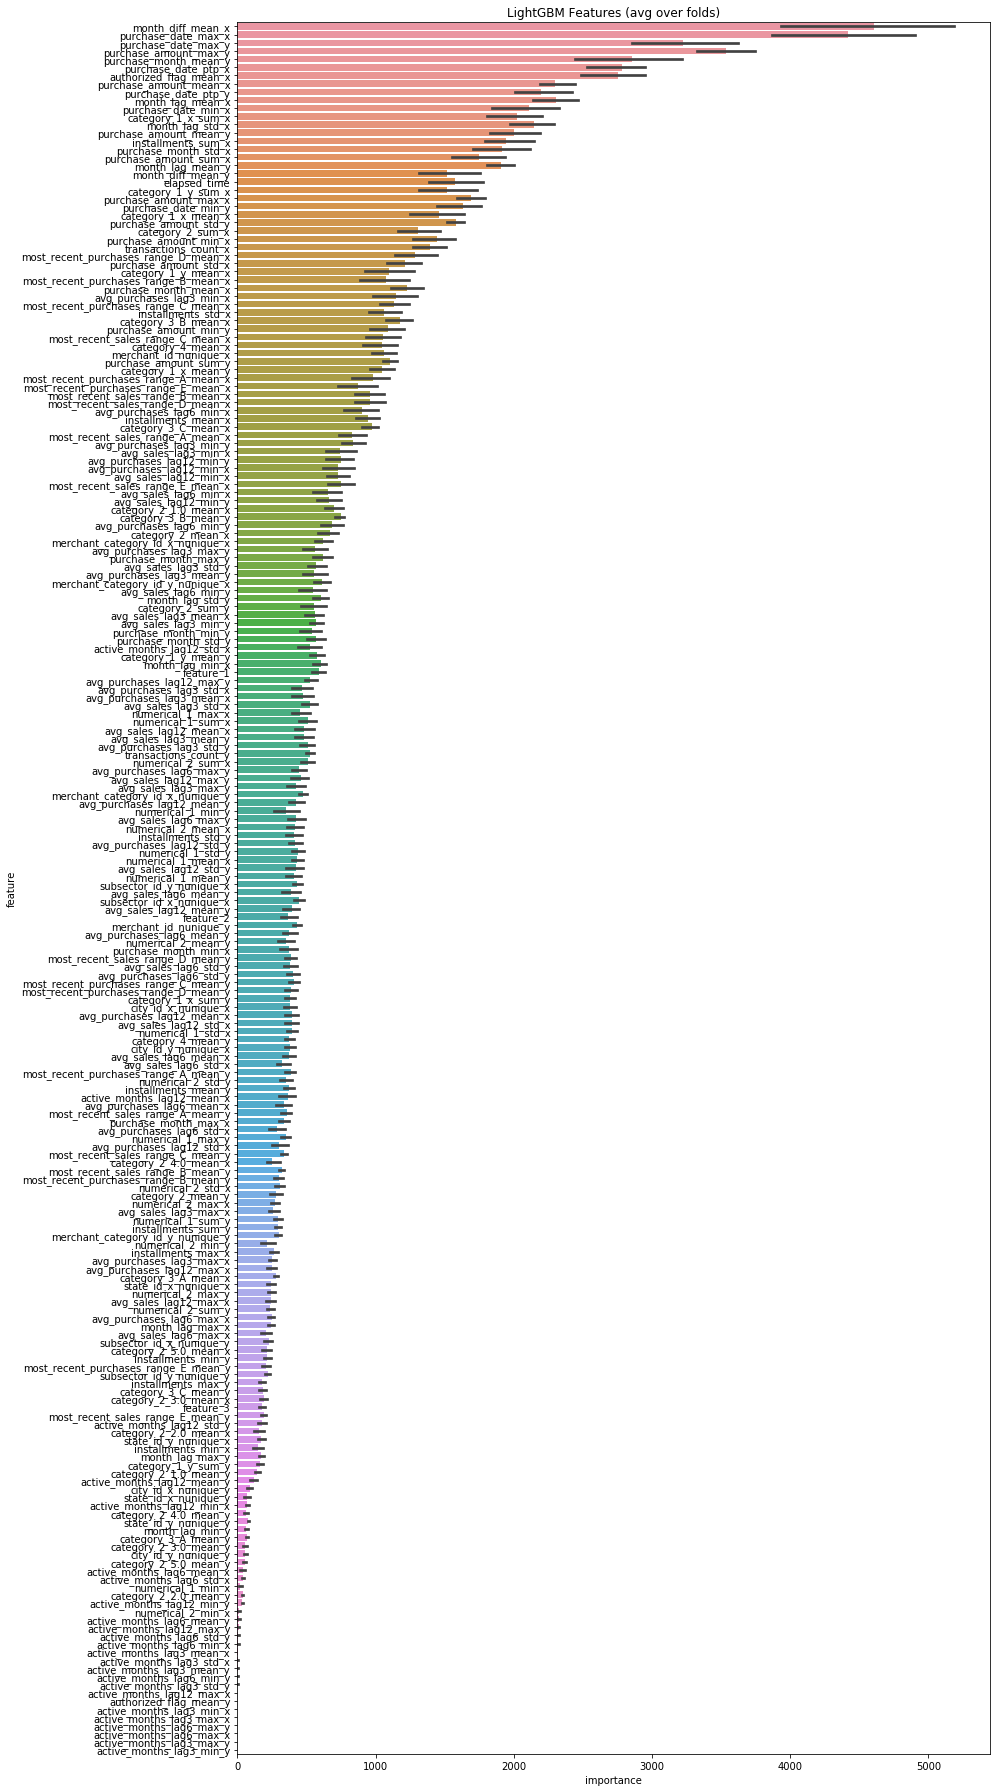

In [98]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')